# WASP Course: Artificial Intelligence and Machine Learning

Lecturer: Dave Zachariah

Assignment responsible: Jingwei Hu, Tianru Zhang, David Vävinggren

# Student and Group Information

Fill this out for the submission of the assignment (you submit this notebook with your solution)

- **Student names:** <font color='red'>Emmanuella Ametsi, Yi Peng</font>

- **Team ID:** <font color='red'>emman_yi</font>

Make sure that the team id is the same as the one with which you submit your model predictions (see coding task 7) such that we can check your performance.

---
# Module 3 - Assignment Overview: ECG classification

The [electrocardiogram (ECG)](https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983) records the electrical signals in the heart. It is a common  test used to quickly detect heart problems and to monitor the heart's health.
In this assignment you will implement and evaluate a model to classify whether the person has [atrial fibrillation (AF)](https://www.mayoclinic.org/diseases-conditions/atrial-fibrillation/symptoms-causes/syc-20350624.) or not based on measurements from the ECG exam.


**Submission:** You submit the deliverables (see below) at https://canvas.kth.se/courses/54581/assignments

**Due Date:** August 22, 2025.

---
## Basic Tasks
Your task is to implement a classification model, train this model on training data, and evaluate its performance on validation data. We provide skeleton code for the implementation of a simple convolution neural network model.

The steps required to implement this model are presented as numbered tasks below. In total there are seven (7) coding tasks and five (5) explanation tasks.

## Competitive setting

You have to compute the predictions for the test data (you do not have the labels for it) and submit your predictions to be evaluated to a leaderboard. These predictions will be scored and your submission will be ranked according to the F1 score and compared with your colleagues. In the end a winning team will be determined.

### Deliverables
There are two deliverables:
1. You have to submit this Jupyter notebook on the course web-page (Canvas) together with your code and explanations (where asked for it) that describe your implementation and your experimental results. The notebook should run as a standalone in google colab.
2. You have to have at least **three (3)** submissions (for instructions on how to submit, see coding task 7) where you try to improve the model architecture, the training procedure or the problem formulation. In the submission of this notebook you have to provide a short explanation of what changed between each submission and justify why you decided to make these changes.

### Grading
To pass the assignment, you must submit a complete and working implementation of a model and a well-motivated description and evaluation of it. Your model should reach an Area under the ROC curve (AUROC) on the test data of at least 0.97 and an Average Precision (AP) score of 0.95. Note that the leaderboard to is sorted by F1 score and not AUROC, hence you would want to balance all three metrics.

### GPU Acceleration
To be able to use the GPUs provided by colab in order to speed up your computations, you want to check that the `Hardware accelerator` is set to `GPU` under `Runtime > change runtime type`. Note that notebooks run by connecting to virtual machines that have maximum lifetimes that can be as much as 12 hours. Notebooks will also disconnect from VMs when left idle for too long.

In [ ]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# clone requirements.txt if not yet available
if not exists('requirements.txt'):
    !git clone https://gist.github.com/dgedon/8a7b91714568dc35d0527233e9ceada4.git req
    !mv req/requirements.txt .
    !yes | rm -r req

requirements.txt already exits. Using cached. Delete it manually to recieve it again!


In [ ]:
# Install packages (python>=3.9 is required)
!pip install -r requirements.txt

In [ ]:
# Import
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

---
## The data set

The dataset is a subset of the [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The ECG exams were recorded in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was described in ["Automatic diagnosis of the 12-lead ECG using a deep neural network"](https://www.nature.com/articles/s41467-020-15432-4).
The full dataset is available for research upon request.


For the training dataset you have labels.
For the test dataset you only have the ECG exams but no labels. Evaluation is done by submitting to the leaderboard.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [ ]:
# 1. Download dataset
file_name = Path("codesubset.tar.gz")

if not file_name.exists():
    !wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

--2025-07-02 11:57:05--  https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/k4v4u6ypfyfrdjwvykikr/codesubset.tar.gz?rlkey=izu84k9fv82sto7zzl4z769zj&dl=0 [following]
--2025-07-02 11:57:06--  https://www.dropbox.com/scl/fi/k4v4u6ypfyfrdjwvykikr/codesubset.tar.gz?rlkey=izu84k9fv82sto7zzl4z769zj&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc95ffc3b4a4a41cb2166d1e9603.dl.dropboxusercontent.com/cd/0/inline/CsuRS7thFMhD6sws4pFhpQo-TwewuLU0_NHFawPCY0NYNMNaz_ZjAdryM2bMsFGUVIXK4JLhu03zhje7fnaWRn8kHCfTxB7dArgCdKIxEoYtgMn5llRSCT7_gb9o0SXRXSk/file# [following]
--2025-07-02 11:57:06--  https://uc95ffc3b4a4a41cb2166d1e9603.dl.dropboxusercontent.com/cd/0

In [ ]:
# 1. unzip the downloaded data set folder
file_name = Path('codesubset')
if not file_name.exists():
    !tar -xf codesubset.tar.gz

Note that the extraced folder 'codesubset' contains
1. subfolders with the ECG exam traces. These have to be further preprocessed which we do in the next steps.
2. a csv file which contain the labels and other features for the training data set.


### Preprocessing

Run the cells below to  Clone the GitHub repository which we use for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).

In [ ]:
# 2. clone the code files for data preprocessing
file_name = Path('ecg-preprocessing')
if not file_name.exists():
    !git clone https://github.com/paulhausner/ecg-preprocessing.git

Cloning into 'ecg-preprocessing'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 43 (delta 19), reused 32 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 386.28 KiB | 13.79 MiB/s, done.
Resolving deltas: 100% (19/19), done.


Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads * sequence length)`. Now we can view an ECG before preprocessing.

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

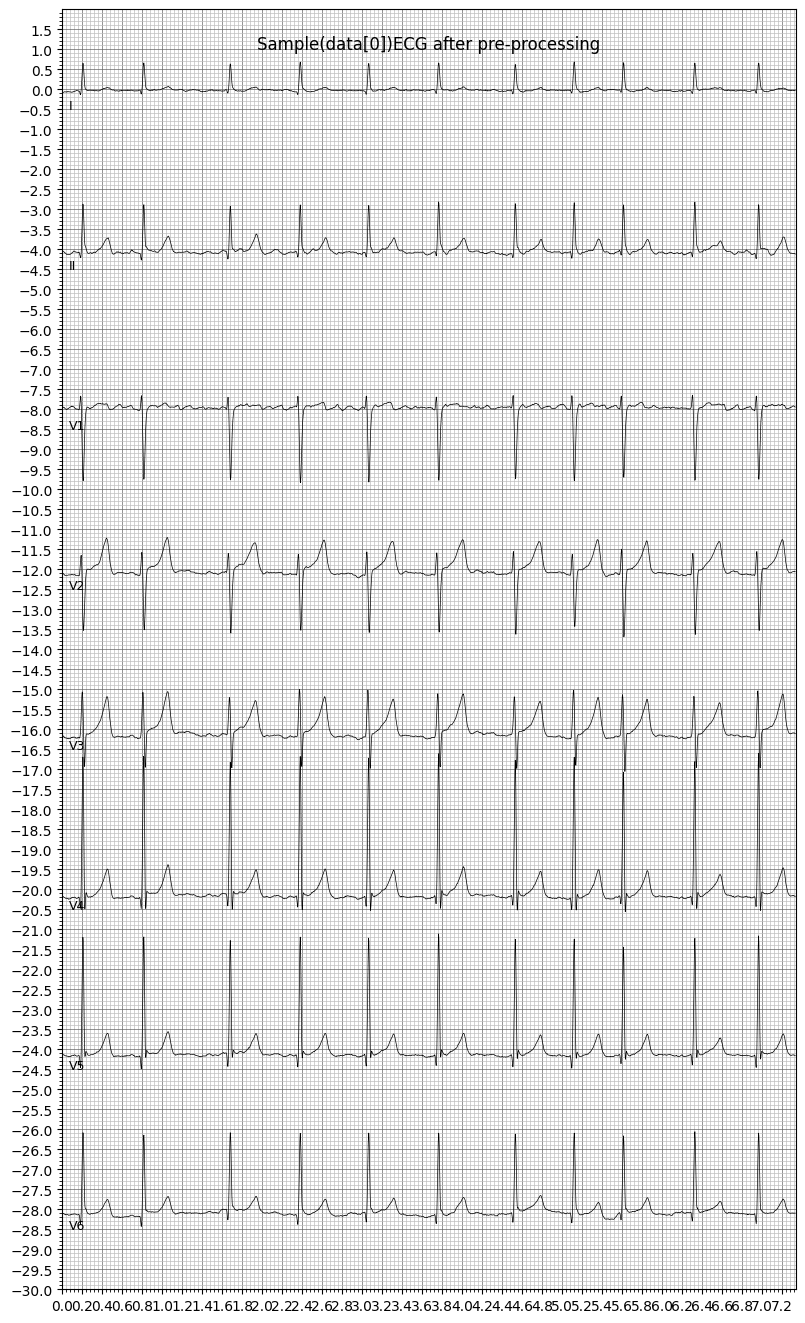

In [ ]:
import ecg_plot
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_WFDB = 'codesubset/train/TNMG100046'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample(data[0])ECG after pre-processing')
plt.show()

#


The preprocessing consist of:
- resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
- zero padding if necessary such that all ECG have the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

Namespace(path='codesubset/train/TNMG100046', save='', remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

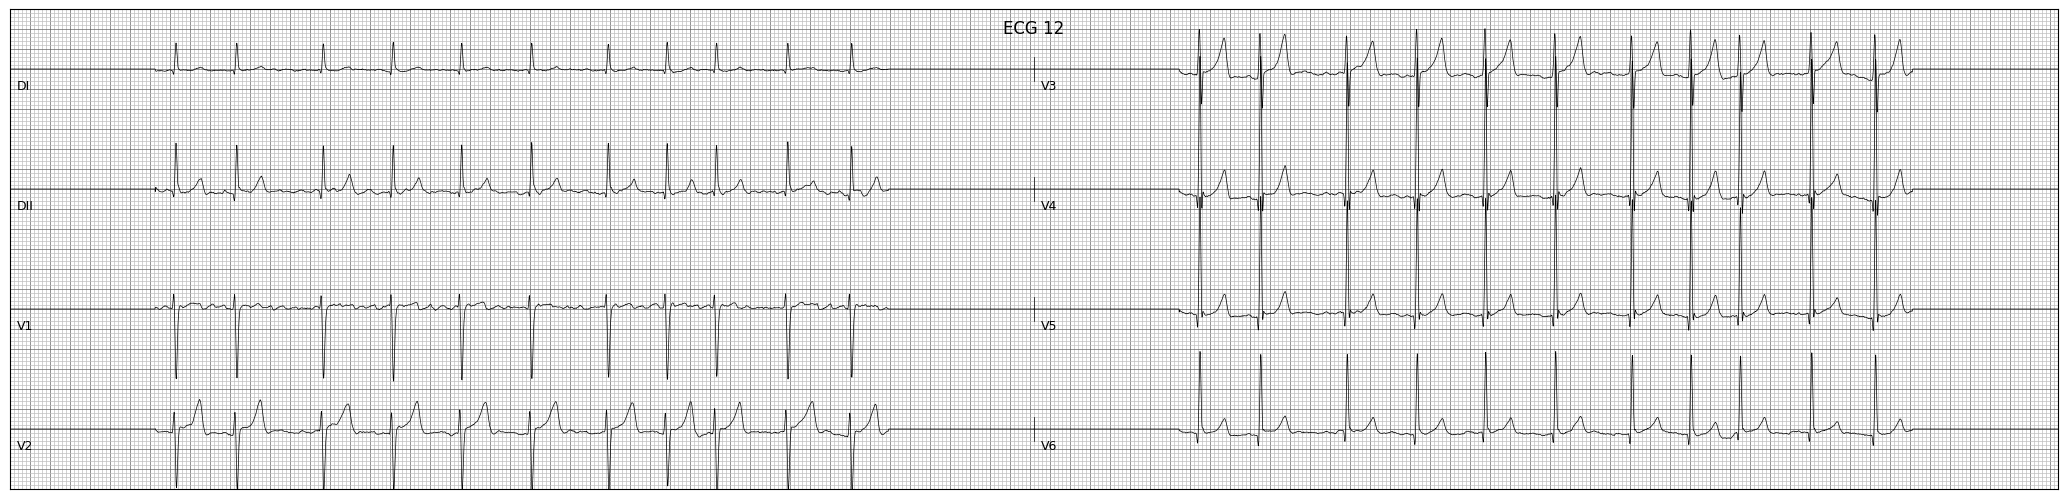

<Figure size 640x480 with 0 Axes>

In [ ]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces * sequence length * number of leads)` where sequence length is 4096 and number of leads is 8.
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [ ]:
# 3. Generate train
if not exists('codesubset/train.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
if not exists('codesubset/test.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

Namespace(input_file='codesubset/train/RECORDS.txt', out_file='codesubset/train.h5', root_dir=None, remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')
100% 10000/10000 [00:58<00:00, 169.77it/s]
Namespace(input_file='codesubset/test/RECORDS.txt', out_file='codesubset/test.h5', root_dir=None, remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')
100% 6000/6000 [00:35<00:00, 170.51it/s]


### Coding Task 1: Data Analysis

Before starting to model you have to analyse the dataset. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
Then, `data[i]` is an numpy array of the $i$th ECG exam (including all time points and leads).


(10000, 4096, 8)
(4096, 8)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

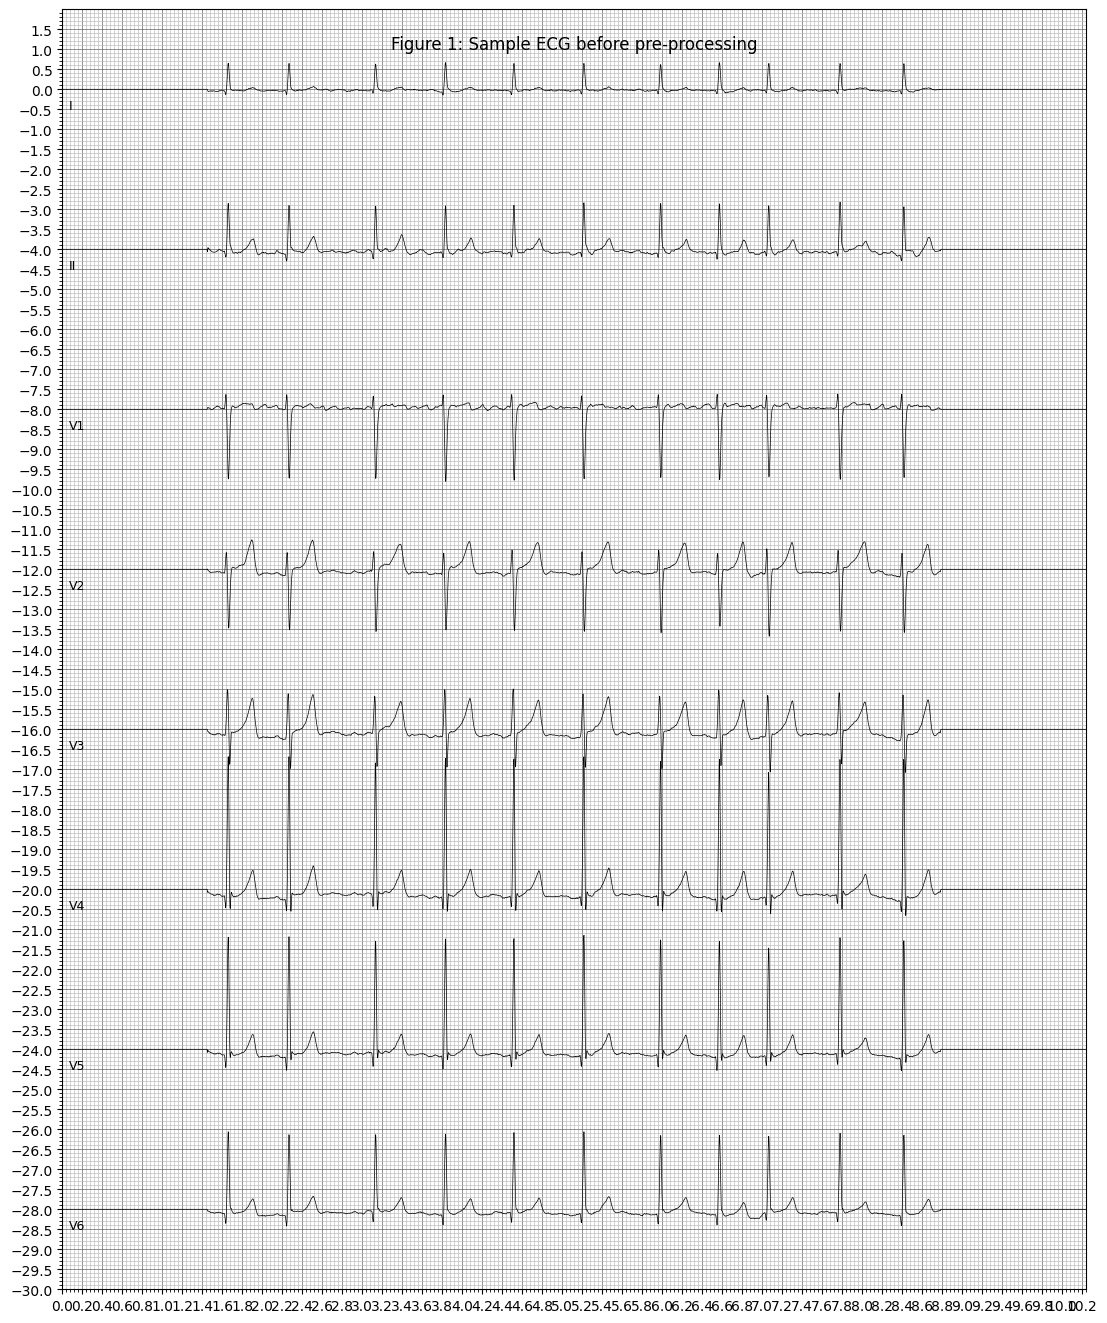

Distribution of Atrial Fibrillation (AF) in the dataset:
AF
0    7000
1    3000
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

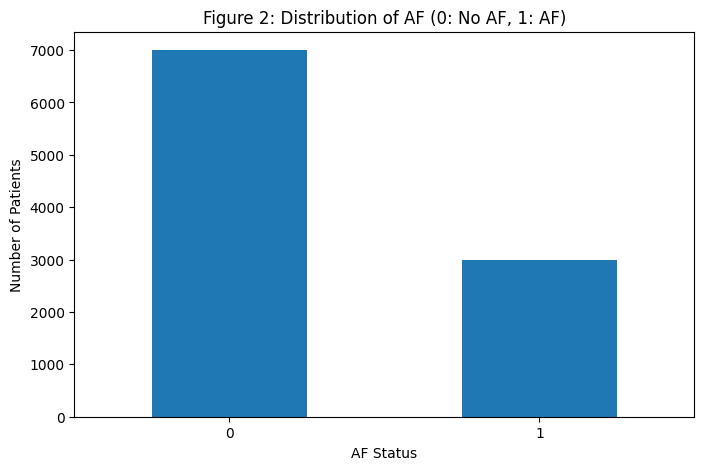

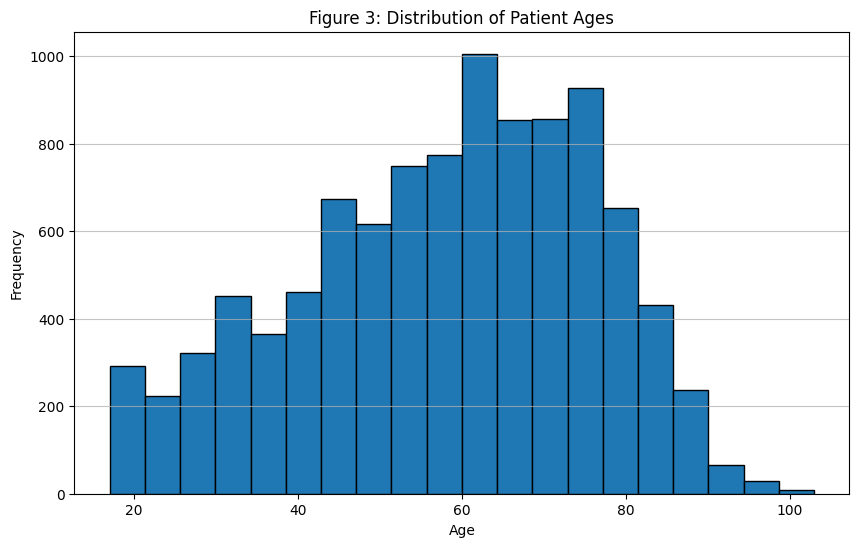

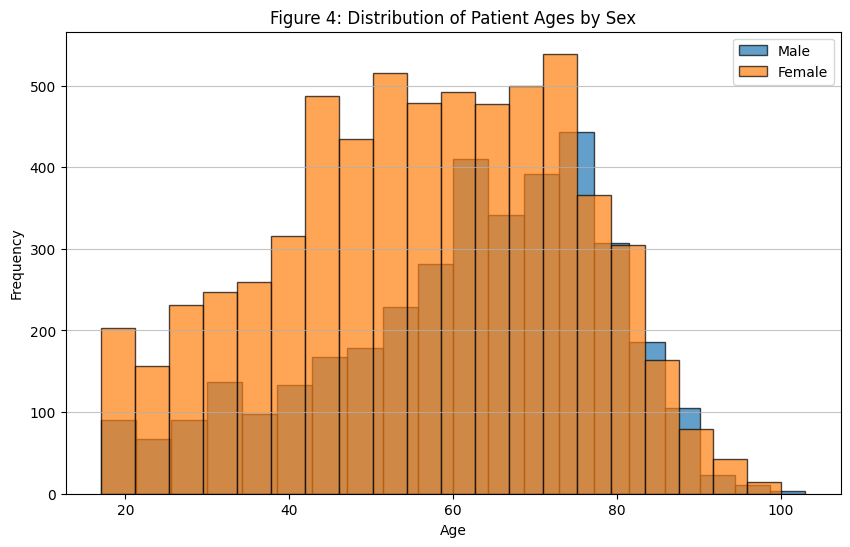

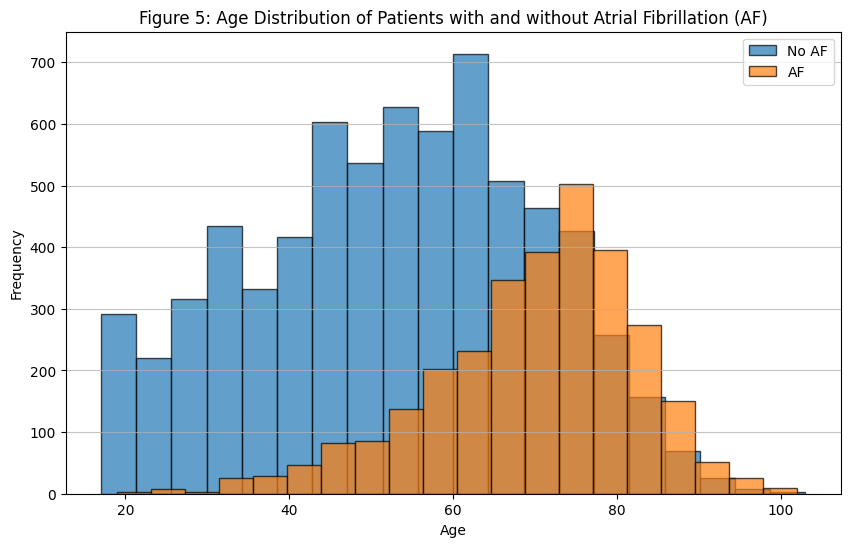

'\nEnd of our code.\n'

In [ ]:
"""
TASK: Insert your code here
"""

import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
print(data.shape)
print(data[1].shape)


#Plot for an ECG example after preprocessing
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(data[0].T, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Figure 1: Sample ECG before pre-processing')
plt.show()

#Reading patient data from csv
patient_data = pd.read_csv('codesubset/train.csv')

#To check balance of dataset, we do plot the distribution of Atrial Fibrillation (AF) in the dataset
af_counts = patient_data['AF'].value_counts()
print("Distribution of Atrial Fibrillation (AF) in the dataset:")
print(af_counts)

# You can also visualize this with a bar plot
plt.figure(figsize=(8, 5))
af_counts.plot(kind='bar')
plt.title('Figure 2: Distribution of AF (0: No AF, 1: AF)')
plt.xlabel('AF Status')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.show()

#Evaluating the distribution of age and sex of the patients using histograms

plt.figure(figsize=(10, 6))
plt.hist(patient_data['age'], bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Figure 3: Distribution of Patient Ages')
plt.grid(axis='y', alpha=0.75)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(patient_data[patient_data['sex'] == 'M']['age'], bins=20, edgecolor='black', alpha=0.7, label='Male')
plt.hist(patient_data[patient_data['sex'] == 'F']['age'], bins=20, edgecolor='black', alpha=0.7, label='Female')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Figure 4: Distribution of Patient Ages by Sex')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

#Evaluating the distribution of patients with and without Atrial Fibrillation (AF)

plt.figure(figsize=(10, 6))
plt.hist(patient_data[patient_data['AF'] == 0]['age'], bins=20, edgecolor='black', alpha=0.7, label='No AF')
plt.hist(patient_data[patient_data['AF'] == 1]['age'], bins=20, edgecolor='black', alpha=0.7, label='AF')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Figure 5: Age Distribution of Patients with and without Atrial Fibrillation (AF)')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

"""
End of our code.
"""

### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary.

<br />


**<font color='red'>Your explanation here:</font>**

What preprocessing does and why it is necessary :
  * The data is resampled at 400HZ so that it captures important frequencies while reducing computational cost and keeping the data volume managable. It is a standard proceedure according to the National Instituite of Health(NIH) and GE Healthcare.
  * Some signals had different durations and in order to make them all have the same sizes, zero-padding was done.
  * According to the original [article](https://www.nature.com/articles/s41467-020-15432-4), removing trends in ECG signals/removing possible powerline noise was done because noise and interference in the baseline are established causes of error and affects both automatic and manual diagnosis of ECG abnomalities.



Main findings from our data analysis:
  * We checked the balance of the dataset by  examining the distribution of the target variable AF in figure 2. The distribution shows that there are more patients without AF than patients with AF and this could be a point of concern for training.

  * We also evaluated the distribution of the ages and sexs of patients in using histograms in figure 3 and 4. We noticed that there are more female patients than males(fig3) and the majority of patients are between 40 to 80 years old.

  * We analysed the age distribution of patients with and without Atrial Fibrillation (AF) in figure 5 and noticed that more older patients tend to have AF than younger ones.






---
## Model

The model class consists of two methods:
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter, **sequence length** is the number of ECG time samples (=4096) and **number of leads** (=8).

The `ModelBaseline` (provided below) is a 2 layer model with one convolutional layers and one linear layer. Some explanations:
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [ ]:
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8,
                               out_channels=32,
                               kernel_size=self.kernel_size,
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)

        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)

        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [ ]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        """
        TASK: Replace the baseline model with your model; Insert your code here
        """
        #self.kernel_size = 3

        # conv layer
        self.conv1 = nn.Conv1d(
            in_channels=8,
            out_channels=32,
            kernel_size=5,
            stride=1,
            padding=2  # (kernel_size - 1) / 2 for 'same' padding
        )

        # Shape after conv1: (batch_size, 32, 4096)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # Shape after pool1: (batch_size, 32, 2048)

        # --- Convolutional Block 2 ---
        self.conv2 = nn.Conv1d(
            in_channels=32,
            out_channels=64,
            kernel_size=5,
            stride=1,
            padding=2
        )
        # Shape after conv2: (batch_size, 64, 2048)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        # Shape after pool2: (batch_size, 64, 1024)

        # --- Fully Connected Layers ---
        # The input features for the linear layer depend on the output of the last pooling layer.
        # Calculation: out_channels_conv2 * (input_seq_length / pool1_stride / pool2_stride)
        # 64 * (4096 / 2 / 2) = 64 * 1024 = 65536
        self.flatten_features = 64 * 1024

        self.fc1 = nn.Linear(in_features=self.flatten_features, out_features=128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

        # --- Output Layer ---
        self.fc2 = nn.Linear(in_features=128, out_features=1)
        #self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = x.transpose(1, 2)

        # Pass through convolutional blocks
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten the features for the fully connected layers
        # x.view(batch_size, features)
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)

        # Output layer
        x = self.fc2(x)
        #x = self.sigmoid(x)

        return x
        """
        End of our code.
        """

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**<font color='red'>Your explanation here:</font>**


---
## Train function

The function `train(...)` is called to in every epoch to train the model. The function loads the training data, makes predictions, compares predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [ ]:
def train_loop(epoch, dataloader, model, optimizer, loss_function, device):
    # model to training mode (important to correctly handle dropout or batchnorm layers)
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    for traces, diagnoses in train_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces.to(device), diagnoses.to(device)

        """
        TASK: Insert your code here. This task can be done in 5 lines of code.
        """
        optimizer.zero_grad()
        output = model(traces)
        loss = loss_function(output, diagnoses)
        loss.backward()
        optimizer.step()

        """
        End of our code.
        """

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({'loss': total_loss / n_entries})
    print(f'loss:{total_loss/32}')
    train_pbar.close()
    return total_loss / n_entries

---
## Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit computing gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUROC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [ ]:
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_probs = []  # accumulated predicted probabilities
    valid_true = [] # accumulated true labels

    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        """
        TASK: Insert your code here. This task can be done in 6 lines of code.
        """
        with torch.no_grad():
          output = model(traces)
          loss = loss_function(output, diagnoses)

          # Convert logits to probabilities for evaluation
          probs = torch.sigmoid(output)

          # Collect true labels and predicted probabilities
          valid_true.extend(diagnoses.cpu().numpy())
          valid_probs.extend(probs.squeeze(1).cpu().numpy())

        """
        End of our code.
        """

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_probs), np.vstack(valid_true)

---
## Run Training

In the code cell below there are some initial (non-optimal!) training hyperparameters. Further, we combine everything from above into training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. Here, we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data into training and validation data
- define the loss function
- decide and implement validation metric(s) to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 5, now you run the code to evaluate the model. Based on the resulting validation metrics you tune
- the training hyperparameters
- the model architecture
- the model hyperparameters.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**<font color='red'>Your explanation here:</font>**


In [ ]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# choose variables
"""
TASK: Adapt the following hyperparameters if necessary
"""
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 100
batch_size = 32

In [ ]:
from torch.utils.data import TensorDataset, random_split, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = torch.tensor(np.array(df['AF']), dtype=torch.float32).reshape(-1,1)
# load dataset
dataset = TensorDataset(traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))
# split data
"""
TASK: Split the dataset in train and validation; Insert your code here.
This can be done in <=4 line of code
"""
train_size = int(0.8 * len_dataset)
valid_size = len_dataset - train_size
dataset_train, dataset_valid = random_split(dataset, [train_size, valid_size])
"""
End of our code.
"""

# build data loaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
tqdm.write("Done!\n")

Use device: cuda

Building data loaders...
Done!



Define model...
Done!

Define optimiser...
Done!

Training...


  0%|          | 0/100 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/250 [00:00<?, ?it/s]

loss:4.195975434035063


Evaluation Epoch  1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.016784 	Valid Loss 0.016807 	AUROC 0.8072 	AP 0.5678 	F1 0.4568 	Best model -> saved


Training Epoch  2:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.753853908739984


Evaluation Epoch  2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.015015 	Valid Loss 0.014226 	AUROC 0.8361 	AP 0.6331 	F1 0.4568 	Best model -> saved


Training Epoch  3:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5855470169335604


Evaluation Epoch  3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.014342 	Valid Loss 0.014308 	AUROC 0.8389 	AP 0.6371 	F1 0.4568 	


Training Epoch  4:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.4476136304438114


Evaluation Epoch  4:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.013790 	Valid Loss 0.014053 	AUROC 0.8505 	AP 0.6728 	F1 0.4568 	Best model -> saved


Training Epoch  5:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.383658521808684


Evaluation Epoch  5:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.013535 	Valid Loss 0.013660 	AUROC 0.8528 	AP 0.6811 	F1 0.4568 	Best model -> saved


Training Epoch  6:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.3626151815988123


Evaluation Epoch  6:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.013450 	Valid Loss 0.013424 	AUROC 0.8568 	AP 0.6740 	F1 0.4568 	Best model -> saved


Training Epoch  7:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.2833533976227045


Evaluation Epoch  7:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.013133 	Valid Loss 0.013826 	AUROC 0.8596 	AP 0.7055 	F1 0.4568 	


Training Epoch  8:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.3181814453564584


Evaluation Epoch  8:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.013273 	Valid Loss 0.013410 	AUROC 0.8625 	AP 0.6950 	F1 0.4568 	Best model -> saved


Training Epoch  9:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.2326154755428433


Evaluation Epoch  9:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.012930 	Valid Loss 0.013792 	AUROC 0.8692 	AP 0.7113 	F1 0.4568 	


Training Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.14678625902161


Evaluation Epoch 10:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.012587 	Valid Loss 0.013228 	AUROC 0.8701 	AP 0.6986 	F1 0.4568 	Best model -> saved


Training Epoch 11:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.1670676106587052


Evaluation Epoch 11:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.012668 	Valid Loss 0.012891 	AUROC 0.8726 	AP 0.7050 	F1 0.4568 	Best model -> saved


Training Epoch 12:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.127022554166615


Evaluation Epoch 12:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.012508 	Valid Loss 0.012650 	AUROC 0.8810 	AP 0.7260 	F1 0.4568 	Best model -> saved


Training Epoch 13:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.085271782707423


Evaluation Epoch 13:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.012341 	Valid Loss 0.012824 	AUROC 0.8755 	AP 0.7164 	F1 0.4570 	


Training Epoch 14:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.0276685068383813


Evaluation Epoch 14:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.012111 	Valid Loss 0.012665 	AUROC 0.8757 	AP 0.7228 	F1 0.4568 	


Training Epoch 15:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.0513774692080915


Evaluation Epoch 15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.012206 	Valid Loss 0.012525 	AUROC 0.8797 	AP 0.7164 	F1 0.4568 	Best model -> saved


Training Epoch 16:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.002781428862363


Evaluation Epoch 16:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16: 	Train Loss 0.012011 	Valid Loss 0.012916 	AUROC 0.8794 	AP 0.7228 	F1 0.4568 	


Training Epoch 17:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.980863533914089


Evaluation Epoch 17:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17: 	Train Loss 0.011923 	Valid Loss 0.013495 	AUROC 0.8767 	AP 0.7250 	F1 0.4570 	


Training Epoch 18:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.9240733231417835


Evaluation Epoch 18:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18: 	Train Loss 0.011696 	Valid Loss 0.012491 	AUROC 0.8880 	AP 0.7317 	F1 0.4568 	Best model -> saved


Training Epoch 19:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.8940285849384964


Evaluation Epoch 19:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19: 	Train Loss 0.011576 	Valid Loss 0.012308 	AUROC 0.8886 	AP 0.7413 	F1 0.4568 	Best model -> saved


Training Epoch 20:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.860977274365723


Evaluation Epoch 20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20: 	Train Loss 0.011444 	Valid Loss 0.011877 	AUROC 0.8925 	AP 0.7512 	F1 0.4568 	Best model -> saved


Training Epoch 21:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.8308541029691696


Evaluation Epoch 21:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21: 	Train Loss 0.011323 	Valid Loss 0.012551 	AUROC 0.8840 	AP 0.7269 	F1 0.4568 	


Training Epoch 22:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.8454894814640284


Evaluation Epoch 22:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22: 	Train Loss 0.011382 	Valid Loss 0.011820 	AUROC 0.8929 	AP 0.7628 	F1 0.4568 	Best model -> saved


Training Epoch 23:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.8105030595324934


Evaluation Epoch 23:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23: 	Train Loss 0.011242 	Valid Loss 0.012128 	AUROC 0.8894 	AP 0.7401 	F1 0.4568 	


Training Epoch 24:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.8204860906116664


Evaluation Epoch 24:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24: 	Train Loss 0.011282 	Valid Loss 0.013113 	AUROC 0.8928 	AP 0.7484 	F1 0.4568 	


Training Epoch 25:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.841725436039269


Evaluation Epoch 25:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25: 	Train Loss 0.011367 	Valid Loss 0.011852 	AUROC 0.8938 	AP 0.7519 	F1 0.4568 	


Training Epoch 26:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.792596908751875


Evaluation Epoch 26:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26: 	Train Loss 0.011170 	Valid Loss 0.011709 	AUROC 0.8951 	AP 0.7659 	F1 0.4568 	Best model -> saved


Training Epoch 27:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.7948409132659435


Evaluation Epoch 27:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27: 	Train Loss 0.011179 	Valid Loss 0.012197 	AUROC 0.8928 	AP 0.7528 	F1 0.4568 	


Training Epoch 28:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.821379058994353


Evaluation Epoch 28:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28: 	Train Loss 0.011286 	Valid Loss 0.012431 	AUROC 0.8941 	AP 0.7609 	F1 0.4568 	


Training Epoch 29:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.7815067605115473


Evaluation Epoch 29:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29: 	Train Loss 0.011126 	Valid Loss 0.012892 	AUROC 0.8907 	AP 0.7497 	F1 0.4568 	


Training Epoch 30:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.7737612444907427


Evaluation Epoch 30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30: 	Train Loss 0.011095 	Valid Loss 0.012066 	AUROC 0.8950 	AP 0.7525 	F1 0.4568 	


Training Epoch 31:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.801428336650133


Evaluation Epoch 31:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31: 	Train Loss 0.011206 	Valid Loss 0.012066 	AUROC 0.8973 	AP 0.7685 	F1 0.4570 	


Training Epoch 32:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.767350861337036


Evaluation Epoch 32:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32: 	Train Loss 0.011069 	Valid Loss 0.011862 	AUROC 0.8930 	AP 0.7601 	F1 0.4568 	


Training Epoch 33:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.7839482072740793


Evaluation Epoch 33:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33: 	Train Loss 0.011136 	Valid Loss 0.011775 	AUROC 0.8939 	AP 0.7610 	F1 0.4568 	


Training Epoch 34:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.7196528161875904


Evaluation Epoch 34:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34: 	Train Loss 0.010879 	Valid Loss 0.011677 	AUROC 0.8984 	AP 0.7751 	F1 0.4570 	Best model -> saved


Training Epoch 35:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.710038859862834


Evaluation Epoch 35:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35: 	Train Loss 0.010840 	Valid Loss 0.011860 	AUROC 0.8943 	AP 0.7643 	F1 0.4568 	


Training Epoch 36:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.733823025599122


Evaluation Epoch 36:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36: 	Train Loss 0.010935 	Valid Loss 0.011864 	AUROC 0.8981 	AP 0.7676 	F1 0.4568 	


Training Epoch 37:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.7538213059306145


Evaluation Epoch 37:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37: 	Train Loss 0.011015 	Valid Loss 0.011841 	AUROC 0.8945 	AP 0.7558 	F1 0.4568 	


Training Epoch 38:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6916978918015957


Evaluation Epoch 38:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38: 	Train Loss 0.010767 	Valid Loss 0.011909 	AUROC 0.8966 	AP 0.7738 	F1 0.4568 	


Training Epoch 39:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.7431596778333187


Evaluation Epoch 39:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39: 	Train Loss 0.010973 	Valid Loss 0.012970 	AUROC 0.8942 	AP 0.7537 	F1 0.4568 	


Training Epoch 40:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6803709934465587


Evaluation Epoch 40:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40: 	Train Loss 0.010721 	Valid Loss 0.011603 	AUROC 0.8964 	AP 0.7668 	F1 0.4568 	Best model -> saved


Training Epoch 41:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6746082121971995


Evaluation Epoch 41:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41: 	Train Loss 0.010698 	Valid Loss 0.011756 	AUROC 0.8965 	AP 0.7671 	F1 0.4568 	


Training Epoch 42:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.641678129788488


Evaluation Epoch 42:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42: 	Train Loss 0.010567 	Valid Loss 0.013701 	AUROC 0.8959 	AP 0.7706 	F1 0.4570 	


Training Epoch 43:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6835081824101508


Evaluation Epoch 43:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43: 	Train Loss 0.010734 	Valid Loss 0.011607 	AUROC 0.8978 	AP 0.7702 	F1 0.4568 	


Training Epoch 44:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6581617235206068


Evaluation Epoch 44:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44: 	Train Loss 0.010633 	Valid Loss 0.011528 	AUROC 0.8985 	AP 0.7714 	F1 0.4568 	Best model -> saved


Training Epoch 45:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.658502070698887


Evaluation Epoch 45:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45: 	Train Loss 0.010634 	Valid Loss 0.011644 	AUROC 0.8993 	AP 0.7650 	F1 0.4568 	


Training Epoch 46:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.670545460190624


Evaluation Epoch 46:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46: 	Train Loss 0.010682 	Valid Loss 0.012335 	AUROC 0.8913 	AP 0.7661 	F1 0.4568 	


Training Epoch 47:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6991641740314662


Evaluation Epoch 47:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47: 	Train Loss 0.010797 	Valid Loss 0.011778 	AUROC 0.8987 	AP 0.7626 	F1 0.4568 	


Training Epoch 48:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.669562838971615


Evaluation Epoch 48:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48: 	Train Loss 0.010678 	Valid Loss 0.011535 	AUROC 0.9032 	AP 0.7794 	F1 0.4568 	


Training Epoch 49:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6524024601094425


Evaluation Epoch 49:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49: 	Train Loss 0.010610 	Valid Loss 0.012212 	AUROC 0.9014 	AP 0.7814 	F1 0.4571 	


Training Epoch 50:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6072755213826895


Evaluation Epoch 50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50: 	Train Loss 0.010429 	Valid Loss 0.011625 	AUROC 0.9011 	AP 0.7720 	F1 0.4568 	


Training Epoch 51:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6817267779260874


Evaluation Epoch 51:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51: 	Train Loss 0.010727 	Valid Loss 0.012086 	AUROC 0.8971 	AP 0.7651 	F1 0.4568 	


Training Epoch 52:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6738946405239403


Evaluation Epoch 52:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52: 	Train Loss 0.010696 	Valid Loss 0.011486 	AUROC 0.9027 	AP 0.7804 	F1 0.4568 	Best model -> saved


Training Epoch 53:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6529478719457984


Evaluation Epoch 53:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53: 	Train Loss 0.010612 	Valid Loss 0.011523 	AUROC 0.9044 	AP 0.7898 	F1 0.4570 	


Training Epoch 54:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6538089965470135


Evaluation Epoch 54:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54: 	Train Loss 0.010615 	Valid Loss 0.011160 	AUROC 0.9059 	AP 0.7857 	F1 0.4568 	Best model -> saved


Training Epoch 55:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.730193193536252


Evaluation Epoch 55:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55: 	Train Loss 0.010921 	Valid Loss 0.011804 	AUROC 0.9017 	AP 0.7906 	F1 0.4571 	


Training Epoch 56:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.5886409524828196


Evaluation Epoch 56:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56: 	Train Loss 0.010355 	Valid Loss 0.011551 	AUROC 0.9065 	AP 0.7955 	F1 0.4570 	


Training Epoch 57:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6081097992137074


Evaluation Epoch 57:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57: 	Train Loss 0.010432 	Valid Loss 0.011403 	AUROC 0.9033 	AP 0.7762 	F1 0.4570 	


Training Epoch 58:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.62136741168797


Evaluation Epoch 58:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58: 	Train Loss 0.010485 	Valid Loss 0.011729 	AUROC 0.8983 	AP 0.7715 	F1 0.4570 	


Training Epoch 59:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6033396967686713


Evaluation Epoch 59:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59: 	Train Loss 0.010413 	Valid Loss 0.011545 	AUROC 0.9033 	AP 0.7807 	F1 0.4568 	


Training Epoch 60:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6049195006489754


Evaluation Epoch 60:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60: 	Train Loss 0.010420 	Valid Loss 0.011574 	AUROC 0.9024 	AP 0.7803 	F1 0.4568 	


Training Epoch 61:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.5731741674244404


Evaluation Epoch 61:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61: 	Train Loss 0.010293 	Valid Loss 0.011125 	AUROC 0.9071 	AP 0.7915 	F1 0.4570 	Best model -> saved


Training Epoch 62:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.5950455153360963


Evaluation Epoch 62:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62: 	Train Loss 0.010380 	Valid Loss 0.011011 	AUROC 0.9092 	AP 0.7941 	F1 0.4570 	Best model -> saved


Training Epoch 63:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.5756556685082614


Evaluation Epoch 63:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63: 	Train Loss 0.010303 	Valid Loss 0.011170 	AUROC 0.9064 	AP 0.7947 	F1 0.4568 	


Training Epoch 64:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6603019535541534


Evaluation Epoch 64:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64: 	Train Loss 0.010641 	Valid Loss 0.011384 	AUROC 0.9050 	AP 0.7956 	F1 0.4571 	


Training Epoch 65:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6119486461393535


Evaluation Epoch 65:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65: 	Train Loss 0.010448 	Valid Loss 0.011125 	AUROC 0.9091 	AP 0.7884 	F1 0.4570 	


Training Epoch 66:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.598656300455332


Evaluation Epoch 66:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66: 	Train Loss 0.010395 	Valid Loss 0.013015 	AUROC 0.9001 	AP 0.7675 	F1 0.4568 	


Training Epoch 67:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6150783766061068


Evaluation Epoch 67:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67: 	Train Loss 0.010460 	Valid Loss 0.011207 	AUROC 0.9049 	AP 0.7856 	F1 0.4568 	


Training Epoch 68:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.568399610929191


Evaluation Epoch 68:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68: 	Train Loss 0.010274 	Valid Loss 0.011408 	AUROC 0.9033 	AP 0.7788 	F1 0.4568 	


Training Epoch 69:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.596849106019363


Evaluation Epoch 69:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69: 	Train Loss 0.010387 	Valid Loss 0.011333 	AUROC 0.9091 	AP 0.7994 	F1 0.4568 	


Training Epoch 70:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.6335526844486594


Evaluation Epoch 70:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70: 	Train Loss 0.010534 	Valid Loss 0.011215 	AUROC 0.9081 	AP 0.8073 	F1 0.4570 	
Epoch 00070: reducing learning rate of group 0 to 1.0000e-04.


Training Epoch 71:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.2851036214269698


Evaluation Epoch 71:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71: 	Train Loss 0.009140 	Valid Loss 0.010978 	AUROC 0.9098 	AP 0.7975 	F1 0.4568 	Best model -> saved


Training Epoch 72:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.221151328412816


Evaluation Epoch 72:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72: 	Train Loss 0.008885 	Valid Loss 0.010952 	AUROC 0.9106 	AP 0.7966 	F1 0.4568 	Best model -> saved


Training Epoch 73:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.179293714929372


Evaluation Epoch 73:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73: 	Train Loss 0.008717 	Valid Loss 0.010975 	AUROC 0.9106 	AP 0.7969 	F1 0.4570 	


Training Epoch 74:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.1762941293418407


Evaluation Epoch 74:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74: 	Train Loss 0.008705 	Valid Loss 0.011098 	AUROC 0.9101 	AP 0.7928 	F1 0.4570 	


Training Epoch 75:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.137557893525809


Evaluation Epoch 75:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75: 	Train Loss 0.008550 	Valid Loss 0.010976 	AUROC 0.9110 	AP 0.7969 	F1 0.4570 	


Training Epoch 76:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.1310253005940467


Evaluation Epoch 76:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76: 	Train Loss 0.008524 	Valid Loss 0.011062 	AUROC 0.9099 	AP 0.7920 	F1 0.4570 	


Training Epoch 77:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.1340839348267764


Evaluation Epoch 77:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77: 	Train Loss 0.008536 	Valid Loss 0.011066 	AUROC 0.9102 	AP 0.7911 	F1 0.4570 	


Training Epoch 78:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.0872617745772004


Evaluation Epoch 78:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78: 	Train Loss 0.008349 	Valid Loss 0.011087 	AUROC 0.9092 	AP 0.7918 	F1 0.4570 	


Training Epoch 79:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.0777247867081314


Evaluation Epoch 79:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79: 	Train Loss 0.008311 	Valid Loss 0.011090 	AUROC 0.9094 	AP 0.7941 	F1 0.4570 	


Training Epoch 80:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.06662723608315


Evaluation Epoch 80:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80: 	Train Loss 0.008267 	Valid Loss 0.011510 	AUROC 0.9069 	AP 0.7881 	F1 0.4570 	
Epoch 00080: reducing learning rate of group 0 to 1.0000e-05.


Training Epoch 81:   0%|          | 0/250 [00:00<?, ?it/s]

loss:2.0000356887467206


Evaluation Epoch 81:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81: 	Train Loss 0.008000 	Valid Loss 0.011122 	AUROC 0.9084 	AP 0.7912 	F1 0.4571 	


Training Epoch 82:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9842070280574262


Evaluation Epoch 82:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82: 	Train Loss 0.007937 	Valid Loss 0.011125 	AUROC 0.9085 	AP 0.7909 	F1 0.4570 	


Training Epoch 83:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9789940840564668


Evaluation Epoch 83:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83: 	Train Loss 0.007916 	Valid Loss 0.011128 	AUROC 0.9083 	AP 0.7902 	F1 0.4570 	


Training Epoch 84:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9587698350660503


Evaluation Epoch 84:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84: 	Train Loss 0.007835 	Valid Loss 0.011147 	AUROC 0.9081 	AP 0.7896 	F1 0.4570 	


Training Epoch 85:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.960815784521401


Evaluation Epoch 85:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85: 	Train Loss 0.007843 	Valid Loss 0.011140 	AUROC 0.9083 	AP 0.7904 	F1 0.4570 	


Training Epoch 86:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9799307994544506


Evaluation Epoch 86:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86: 	Train Loss 0.007920 	Valid Loss 0.011142 	AUROC 0.9082 	AP 0.7898 	F1 0.4570 	


Training Epoch 87:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9648344384040684


Evaluation Epoch 87:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87: 	Train Loss 0.007859 	Valid Loss 0.011152 	AUROC 0.9080 	AP 0.7893 	F1 0.4570 	


Training Epoch 88:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9580455655232072


Evaluation Epoch 88:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88: 	Train Loss 0.007832 	Valid Loss 0.011157 	AUROC 0.9082 	AP 0.7903 	F1 0.4570 	
Epoch 00088: reducing learning rate of group 0 to 1.0000e-06.


Training Epoch 89:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9556382491718978


Evaluation Epoch 89:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89: 	Train Loss 0.007823 	Valid Loss 0.011151 	AUROC 0.9081 	AP 0.7900 	F1 0.4570 	


Training Epoch 90:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9527266474906355


Evaluation Epoch 90:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90: 	Train Loss 0.007811 	Valid Loss 0.011150 	AUROC 0.9081 	AP 0.7899 	F1 0.4570 	


Training Epoch 91:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9447256256826222


Evaluation Epoch 91:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91: 	Train Loss 0.007779 	Valid Loss 0.011152 	AUROC 0.9081 	AP 0.7897 	F1 0.4570 	


Training Epoch 92:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.960806141840294


Evaluation Epoch 92:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92: 	Train Loss 0.007843 	Valid Loss 0.011152 	AUROC 0.9081 	AP 0.7898 	F1 0.4570 	


Training Epoch 93:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.962605909910053


Evaluation Epoch 93:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93: 	Train Loss 0.007850 	Valid Loss 0.011152 	AUROC 0.9081 	AP 0.7898 	F1 0.4570 	


Training Epoch 94:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9447478149086237


Evaluation Epoch 94:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94: 	Train Loss 0.007779 	Valid Loss 0.011153 	AUROC 0.9081 	AP 0.7897 	F1 0.4570 	


Training Epoch 95:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9426275040023029


Evaluation Epoch 95:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95: 	Train Loss 0.007771 	Valid Loss 0.011153 	AUROC 0.9081 	AP 0.7898 	F1 0.4570 	


Training Epoch 96:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9483685679733753


Evaluation Epoch 96:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96: 	Train Loss 0.007793 	Valid Loss 0.011154 	AUROC 0.9081 	AP 0.7899 	F1 0.4570 	
Epoch 00096: reducing learning rate of group 0 to 1.0000e-07.


Training Epoch 97:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9404760808683932


Evaluation Epoch 97:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97: 	Train Loss 0.007762 	Valid Loss 0.011154 	AUROC 0.9081 	AP 0.7899 	F1 0.4570 	


Training Epoch 98:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9461870323866606


Evaluation Epoch 98:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98: 	Train Loss 0.007785 	Valid Loss 0.011154 	AUROC 0.9081 	AP 0.7899 	F1 0.4570 	


Training Epoch 99:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9369080525357276


Evaluation Epoch 99:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99: 	Train Loss 0.007748 	Valid Loss 0.011154 	AUROC 0.9081 	AP 0.7899 	F1 0.4570 	


Training Epoch 100:   0%|          | 0/250 [00:00<?, ?it/s]

loss:1.9491951409727335


Evaluation Epoch 100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100: 	Train Loss 0.007797 	Valid Loss 0.011154 	AUROC 0.9081 	AP 0.7899 	F1 0.4570 	


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

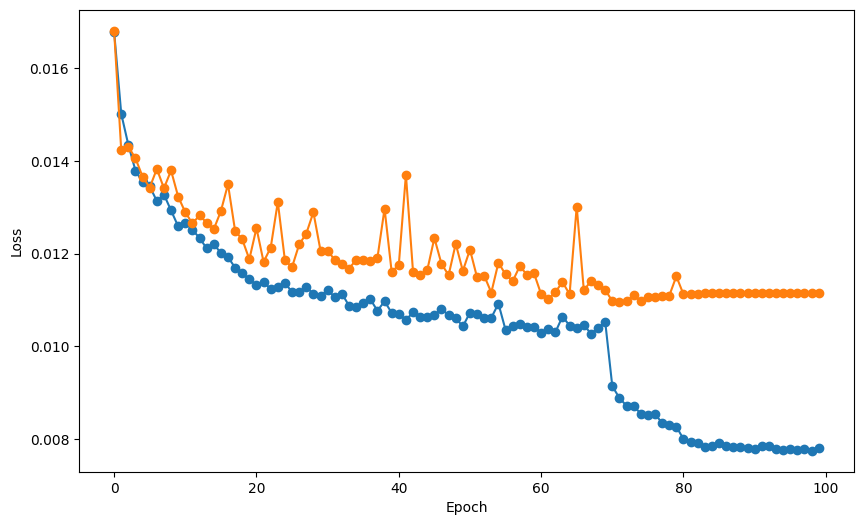

In [ ]:
# =============== Define model ============================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = Model()
model.to(device=device)
tqdm.write("Done!\n")

# =============== Define loss function ====================================#
"""
TASK: define the loss; Insert your code here. This can be done in 1 line of code
"""
loss_function = nn.BCEWithLogitsLoss()
"""
End of our code.
"""

# =============== Define optimizer ========================================#
tqdm.write("Define optimiser...")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
tqdm.write("Done!\n")

# =============== Define lr scheduler =====================================#
# TODO advanced students (non mandatory)
"""
OPTIONAL: define a learning rate scheduler; Insert your code here
"""
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',      # The scheduler will step when the quantity monitored has stopped decreasing
    factor=0.1,      # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=7,      # Number of epochs with no improvement after which learning rate will be reduced
    verbose=True     # If True, prints a message to stdout for each update.
)

# =============== Train model =============================================#
tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all = [], []

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    train_loss = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader, model, loss_function, device)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)

    # compute validation metrics for performance evaluation
    """
    TASK: compute validation metrics (e.g. AUROC); Insert your code here
    This can be done e.g. in 5 lines of code
    """
    from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

    # Assuming y_pred contains raw logits and y_true contains binary labels (0 or 1)
    # Apply sigmoid to y_pred to get probabilities for the positive class
    y_pred_prob = torch.sigmoid(torch.tensor(y_pred)).numpy()

    # Calculate metrics
    auc = roc_auc_score(y_true, y_pred_prob)
    ap = average_precision_score(y_true, y_pred_prob)

    # For F1 score, we need binary predictions. A common threshold is 0.5
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    f1 = f1_score(y_true, y_pred_binary)


    # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, 'model.pth')
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                'AUROC {auc:.4f} \t'
                'AP {ap:.4f} \t'
                'F1 {f1:.4f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        auc=auc,
                        ap=ap,
                        f1=f1,
                        model_save=model_save_state)
                    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step(valid_loss)
"""
TASK: Here it can make sense to plot your learning curve; Insert your code here
"""
plt.figure(figsize=(10, 6))
plt.plot(train_loss_all, label='Training Loss', marker='o')
plt.plot(valid_loss_all, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt

---
## Model Testing

Since we saved our best model, we can now load the trained model and make predictions on the test data set. We save the predictions in a csv file which will be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obtain soft predictions (probabilities) instead of hard predictions (0s or 1s).

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model)
- run the script. The predictions are saved in the variable `soft_pred`.
- upload your predictions to the leaderboard online (see instruction details below).

In [ ]:
# build the dataloader once and re-use when running the cell below possibly multiple times.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = 'codesubset/test.h5', 'codesubset/test.csv'
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'][()], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
tqdm.write("Done!\n")

Building data loaders...
Done!



In [ ]:
# =============== Define model ================================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = Model()

# load stored model parameters
ckpt = torch.load('model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(ckpt['model'])
# put model on device
model.to(device=device)
tqdm.write("Done!\n")

# =============== Evaluate model ==============================================#
model.eval()
# allocation
test_pred = torch.zeros(len_dataset,1)
# progress bar def
test_pbar = tqdm(test_dataloader, desc="Testing")
# evaluation loop
end=0
for traces in test_pbar:
    # data to device
    traces = traces[0].to(device)
    start = end
    with torch.no_grad():
        # Forward pass
        model_output = model(traces)

        # store output
        end = min(start + len(model_output), test_pred.shape[0])
        test_pred[start:end] = torch.nn.Sigmoid()(model_output).detach().cpu()

test_pbar.close()

# =============== Save predictions ============================================#
soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()

Define model...
Done!



Testing:   0%|          | 0/188 [00:00<?, ?it/s]

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a **team id** and **password**. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
    - For each submission you have to attach a note for you to keep track of the submission in the leaderboard and for us to know which submission you refer to in your explanation. Choose something meaningful such as "submission A" or "model B".
    - You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be overwritten and thus only the final submission will be evaluated.
    - Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn't count)
    - The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [ ]:
# 1. Download repository for leaderboard submission system
if not exists('leaderboard'):
    !git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

Cloning into 'leaderboard'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (3/3), done.


In [ ]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password.
Do not change this after you have registered your team
"""
team_id = 'emman_yi' #Fill in a string
password = '123456789' #Fill in a string

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")

Team registered successfully! Good luck


In [ ]:
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""
note = 'first baseline' #Fill in a string

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
r = submit(team_id, password, soft_pred.tolist(), note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")

Submission successful!


### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />


**<font color='red'>Your explanation here:</font>**

Your team id: **<font color='red'>Fill in</font>**

| Submission note | Accuracy | F1 | AUC | AP | Submission description |
| --------------- | -------- | -- | --  | -- | ---------------------- |
|xxx              | 0        | 0  | 0   | 0  | desc                   |
|xxx              | 0        | 0  | 0   | 0  | desc                   |
|xxx              | 0        | 0  | 0   | 0  | desc                   |

### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**<font color='red'>Your explanation here:</font>**